In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import json, os
import string
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
max_len = 16


In [2]:
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams.update({'font.size': 22})


In [3]:
files = os.listdir("savefolder")


In [4]:
def get_f1s(cm):
    p = [cm[i][i]/(0.00001+cm[i][i]+cm[i][i-1]) for i in range(2)]
    r = [cm[i][i]/(0.00001+cm[i][i]+cm[i-1][i]) for i in range(2)]
    return [2*pp*rr/(pp+rr+0.00001) for pp, rr in zip(p, r)]


In [5]:
def get_maj_f1(cm):
    return get_f1s([[cm[0][0]+cm[0][1], cm[1][0]+cm[1][1]], [0,0]])


In [6]:
def get_rand_f1(cm):
    return get_f1s([[(cm[0][0]+cm[0][1])//2, (cm[0][1]+cm[0][1])//2]]*2)


In [7]:
sum_ct = lambda x: x[0][0] + x[0][1] + x[1][0] + x[1][1]


In [8]:
get_file_names = {unique: [] for unique in set(['.'.join(file.split('.')[:5]) if 'corpus.txt' not in file else '.'.join(file.split('.')[:3])
              for file in files])}

for file in files:
    for k in get_file_names:
        if k not in file:
            continue
        s = file.replace(k, '').replace('.txt', '').replace('.vec', '').strip('.')
        get_file_names[k].append('.'.join(s.split('.')[:-1]))


In [9]:
mapped_folders = {k.strip('prd.corpus'): ['savefolder/' + file + '/' for file in files if lr in file and k in file]
 for k, lr in [(k, Counter(v).most_common()[0][0]) for k, v in get_file_names.items()]}


In [10]:
conf_mat_lenwise = {k: {l: [[0, 0], [0, 0]] for l in range(max_len)}
               for k in mapped_folders}

for run_type, runs in mapped_folders.items():
    for run in runs:
        for c in string.ascii_lowercase:
            preds, gndts, _, tokens, _ = json.load(open(run + "/preds_" + c + ".json"))
            for p, g, t in zip(preds, gndts, tokens):
                conf_mat_lenwise[run_type][min(len(t), max_len-1)][p][g] += 1
    print(run_type)

0.2.ran
0.1.gpt
0.1.ran
0.5.ran
txt
0.2.gpt
0.5.gpt


In [11]:
lenwise_stats = {k: {l: {'f1': sum(get_f1s(cm))/2, 'pos_f1': get_f1s(cm)[1]}
                      for l, cm in conf_mats.items()
                    }
    for k, conf_mats in conf_mat_lenwise.items()}


In [12]:
lenwise_stats


{'0.2.ran': {0: {'f1': 0.0, 'pos_f1': 0.0},
  1: {'f1': 0.0, 'pos_f1': 0.0},
  2: {'f1': 0.6851855988630786, 'pos_f1': 0.4718809298934825},
  3: {'f1': 0.6055029043158077, 'pos_f1': 0.4411597915521279},
  4: {'f1': 0.6024475651958245, 'pos_f1': 0.5194987783173559},
  5: {'f1': 0.5946991628080405, 'pos_f1': 0.5713913692730669},
  6: {'f1': 0.5905443351953078, 'pos_f1': 0.6191012918540008},
  7: {'f1': 0.5892750351571022, 'pos_f1': 0.6546772488685604},
  8: {'f1': 0.5783334694729115, 'pos_f1': 0.6994203064751202},
  9: {'f1': 0.5756867075744692, 'pos_f1': 0.7302364362747962},
  10: {'f1': 0.5746734121316261, 'pos_f1': 0.7525758643873244},
  11: {'f1': 0.5672753983482894, 'pos_f1': 0.7814213308218899},
  12: {'f1': 0.5706281093739038, 'pos_f1': 0.8022595256066025},
  13: {'f1': 0.5817219918417318, 'pos_f1': 0.814611755524957},
  14: {'f1': 0.5835408612398031, 'pos_f1': 0.8066700583695798},
  15: {'f1': 0.560737317865063, 'pos_f1': 0.799470749536771}},
 '0.1.gpt': {0: {'f1': 0.0, 'pos_f1':

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


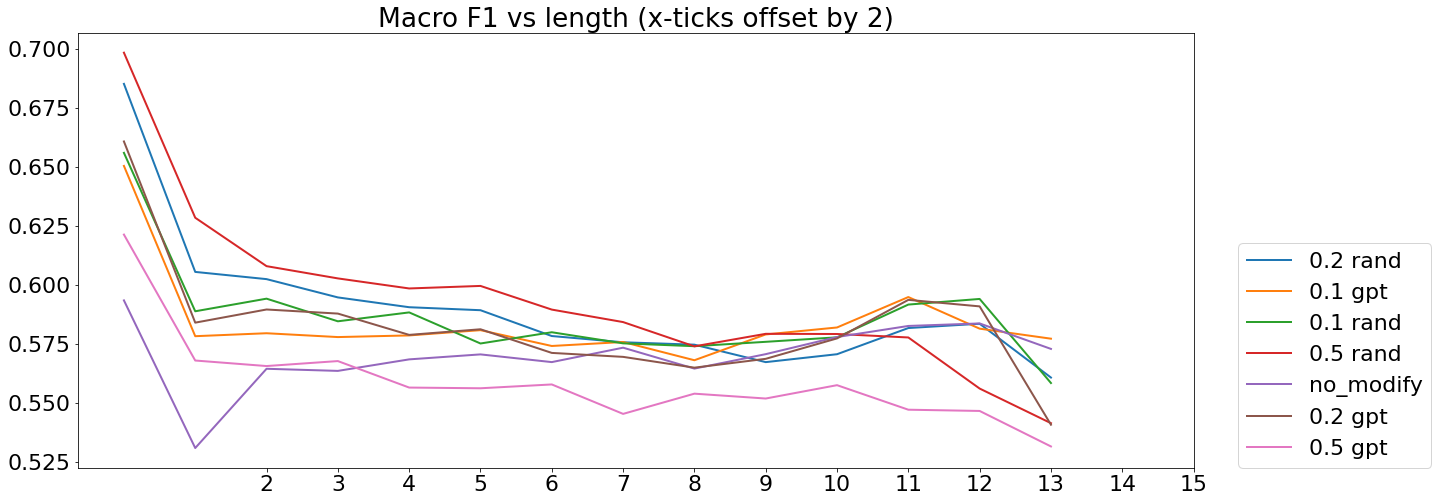

In [13]:
x_labels = list(range(2, max_len))
lines_labels = lenwise_stats.keys()
line_values = [[lenwise_stats[k][l]['f1'] for l in x_labels] for k in lines_labels]
fig, ax = plt.subplots()
for lbl, lin in zip(lines_labels, line_values):
    plt.plot(lin,
             linewidth=2,
             label=lbl.replace('.ran', ' rand').replace('txt', 'no_modify').replace('.gpt', ' gpt'))

print(x_labels)
ax.set_xticks(x_labels)
ax.set_xticklabels(x_labels)

# plt.axis('off')
plt.title('Macro F1 vs length (x-ticks offset by 2)')
plt.legend(loc=(1.04,0))
plt.show()


[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


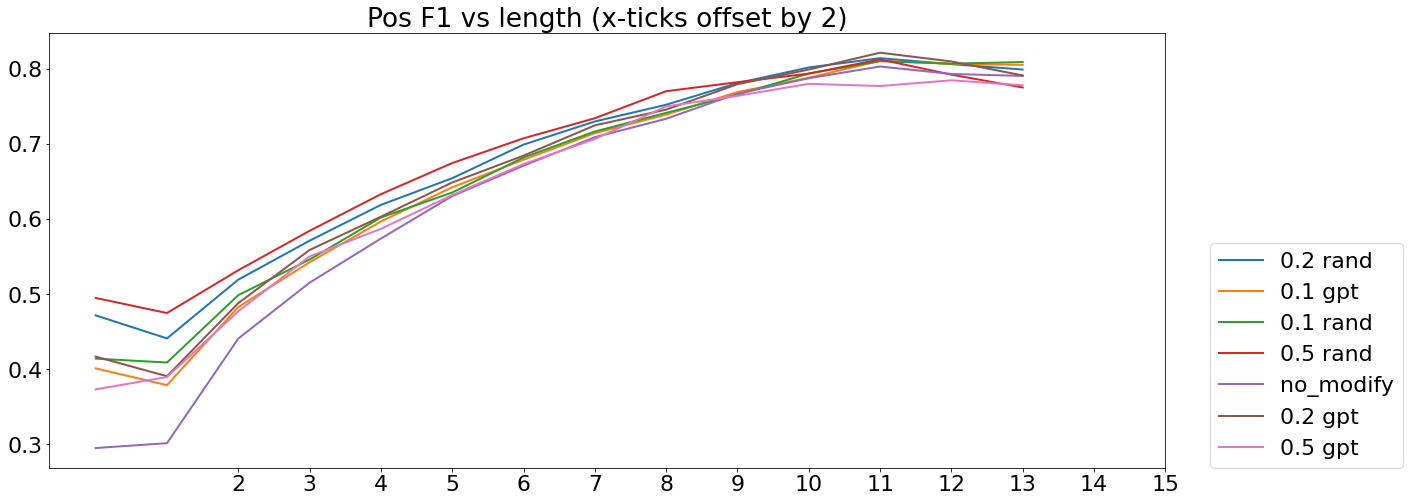

In [14]:
x_labels = list(range(2, max_len))
lines_labels = lenwise_stats.keys()
line_values = [[lenwise_stats[k][l]['pos_f1'] for l in x_labels] for k in lines_labels]
fig, ax = plt.subplots()
for lbl, lin in zip(lines_labels, line_values):
    plt.plot(lin,
             linewidth=2,
             label=lbl.replace('.ran', ' rand').replace('txt', 'no_modify').replace('.gpt', ' gpt'))

print(x_labels)
ax.set_xticks(x_labels)
ax.set_xticklabels(x_labels)

# plt.axis('off')
plt.title('Pos F1 vs length (x-ticks offset by 2)')
plt.legend(loc=(1.04,0))
plt.show()


In [15]:
headers = ['name'] + [h_type + f"_{length}" for h_type in ['f1', 'pos_f1']
                      for length in range(0, max_len)]
rows = [[k.replace('.ran', ' rand').replace('txt', 'no_modify').replace('.gpt', ' gpt')] + 
        [str(v[l]['f1']) for l in range(0, max_len)] + 
        [str(v[l]['pos_f1']) for l in range(0, max_len)]
    for k, v in lenwise_stats.items()]


In [16]:
open("word2vec_lenwise.csv", 'w+').write('\n'.join(
    [','.join(row) for row in [headers]+rows]))


4126